In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

# Step 1: Generate the data 
I'm aiming to generate 100000 datapoints from a Gaussian mixture model of k = 15 components. For simplicity, each datapoint is a scalar (1-dimension). 
To make it more realistic, I will random the weight of each component.

In [2]:
n = 100000 # Number of datapoints
k = 15 # Number of components

# Randomising the weights
weights = np.random.uniform(low = 0.75, high = 1, size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.0000001 # Ensuring a convex linear combination

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-12.5, high=12.5, size=(k, ))
variance = np.random.uniform(low=0.75, high=1.5, size=(k, ))


In [3]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

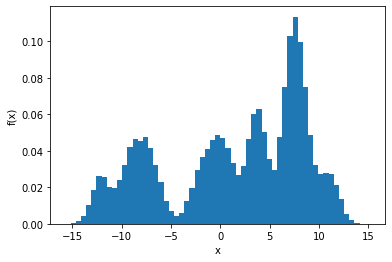

In [4]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [5]:

# First, define a way to calculate pdf 
# This function is actually not used due to its low efficiency. See function calculate_p_matrix below
def pdf(x, input_mean, input_var):
    return math.exp(-0.5 * ((x - input_mean) ** 2 ) / input_var) / (math.sqrt(2 * math.pi * input_var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [6]:
# Using numpy to calculate pdf
# Note that this p matrix is not yet normalised
def calculate_p_matrix(x, input_mean, input_var, input_weight):
    # Duplicate data so dimensions work out
    mean_matrix = np.tile(input_mean, (len(x), 1)).T
    variance_matrix = np.tile(input_var, (len(x), 1)).T
    weight_matrix = np.tile(input_weight, (len(x), 1)).T
    
    # PDF calculation
    p_matrix = weight_matrix * np.exp(-0.5 * np.power(x - mean_matrix, 2) / variance_matrix) / (np.sqrt(2 * np.pi * variance_matrix))
    
    p_matrix = p_matrix.transpose(1, 0)
    
    return p_matrix


In [7]:
# Define a metric to evaluate our return from EM alg.
# Hardcoded P_value to save time

# Old implementation
old_P_value = np.zeros((n,))
for i in range(n):
    for j in range(k):
        old_P_value[i] += weights[j] * pdf(data[i], mean[j], variance[j])


# New implementation with numpy, more efficient
P_value = np.sum(calculate_p_matrix(data, mean, variance, weights), axis = 1)
   
print("new", P_value)
print("old", old_P_value)

new [0.09972086 0.02745322 0.11151248 ... 0.04918704 0.04773083 0.03839223]
old [0.09972086 0.02745322 0.11151248 ... 0.04918704 0.04773083 0.03839223]


In [8]:

# KL divergence is an integral from -inf to +inf, in this case, I only use the n datapoints that we already generated.
# The addition of - P + Q was inspired by scipy's implementation of KL divergence. Apparently, it prevents KL divergence from going negative
def KL_div(pred_mean, pred_variance, pred_weights):
    # Old implementation
    """KL_divergence = 0
    for i in range(n):
        Q_value = 0
        for j in range(k):
            Q_value += pred_weights[j] * pdf(data[i], pred_mean[j], pred_variance[j])
            #P_value += weights[j] * pdf(data[i], mean[j], variance[j])
        KL_divergence += P_value[i] * math.log(P_value[i]/Q_value, math.e) - P_value[i] + Q_value"""
    
    
    # New implementation
    Q_value = np.sum(calculate_p_matrix(data, pred_mean, pred_variance, pred_weights), axis = 1)
    
    KL_divergence = np.sum(P_value * np.log(P_value / Q_value) - P_value + Q_value)
    
    return KL_divergence
    
assert KL_div(mean, variance, weights) == 0



In [19]:
# This implementation is based on Dr. Martha White's notes for CMPUT367, page 107. 

"""scaling_factor_plot = [[] for j in range(k)]
print(scaling_factor_plot)
"""


# Starts with random means, variances and weights
predicted_mean_traditional = np.random.uniform(low=-5, high=5, size=(k, ))
predicted_variance_traditional = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_traditional = np.random.random(size=(k, ))
predicted_weights_traditional = predicted_weights_traditional / np.sum(predicted_weights_traditional) #normalising

def traditional_EM():

    
    global predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    
    
    while prev_divergence - KL_divergence > 0.0001 and KL_divergence > 0:
        
        # This is the old implementation using python loops. I need to redo this part in numpy to optimise bc it takes too much time.
        """for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
            
            denominator_sum = np.sum(probability_matrix[i, :])
            
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum"""
        
        probability_matrix = calculate_p_matrix(data, predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
        # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
        
        """for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
            scaling_factor_plot[j].append(np.sum(probability_matrix[:, j]))"""
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
        
        
        # Maximisation step
        predicted_weights_traditional = (1/n) * np.sum(probability_matrix, axis = 0)
        
        mean_matrix = (data * normalised_p_matrix.T).T
        predicted_mean_traditional = np.sum(mean_matrix, axis = 0)

        predicted_variance_traditional = np.sum(np.multiply(np.power(np.tile(data, (k, 1)).T - predicted_mean_traditional, 2), normalised_p_matrix), axis = 0)
        
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
        
        if counter % 15 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
    return divergence_plot



In [20]:
# Will take abt 5 to 10 minutes to run and converge
divergence_plot = traditional_EM()

kl div: 8361.293008098175
kl div: 218.9404803250058  |  iter: 0  |  difference vs the prev iter: inf
kl div: 86.90113525067945  |  iter: 15  |  difference vs the prev iter: 14.997907588345171
kl div: 33.04538513725702  |  iter: 30  |  difference vs the prev iter: 0.16885046411981364
kl div: 21.34691410849861  |  iter: 45  |  difference vs the prev iter: 1.248883983643779
kl div: 18.023187051703292  |  iter: 60  |  difference vs the prev iter: 0.07630593064108027
kl div: 16.342356100666173  |  iter: 75  |  difference vs the prev iter: 0.12863567812549448
kl div: 14.027308045426768  |  iter: 90  |  difference vs the prev iter: 0.17431900611198436
kl div: 10.780813944324885  |  iter: 105  |  difference vs the prev iter: 0.2468555043910019
kl div: 7.18364958064344  |  iter: 120  |  difference vs the prev iter: 0.1986917374197681
kl div: 5.387925301324608  |  iter: 135  |  difference vs the prev iter: 0.08902542637014665
kl div: 4.158274496064383  |  iter: 150  |  difference vs the prev ite

In [11]:
print("----- TARGET DISTRIBUTION ------")
for i in range(k):
    print("component mean:", mean[i], "| variance:", variance[i], "| weight:", weights[i])

print("----- LEARNED DISTRIBUTION ------")
for i in range(k):
    print("component mean:", predicted_mean_traditional[i], "| variance:", predicted_variance_traditional[i], "| weight:", predicted_weights_traditional[i])

----- TARGET DISTRIBUTION ------
component mean: 11.093515655056404 | variance: 0.9983776144137878 | weight: 0.06567074826540348
component mean: 8.024995084401809 | variance: 1.461246521961342 | weight: 0.06175619075881928
component mean: -2.0381053017064694 | variance: 1.0235335697928143 | weight: 0.06886512527122608
component mean: 3.8593947734665406 | variance: 0.822514869754634 | weight: 0.06992856462694051
component mean: 7.569893340114202 | variance: 1.4414188689789331 | weight: 0.06360918298076429
component mean: 7.608672593621478 | variance: 1.336110921308137 | weight: 0.061188084903013897
component mean: -12.043657481467651 | variance: 0.8531704703894271 | weight: 0.06263635100308068
component mean: 0.7451741210689722 | variance: 1.432735783961118 | weight: 0.06886432483258784
component mean: -9.220190512949511 | variance: 0.915729795797464 | weight: 0.06847802577982
component mean: 7.364692120203532 | variance: 0.8148863630258516 | weight: 0.06118955240794563
component mean: 

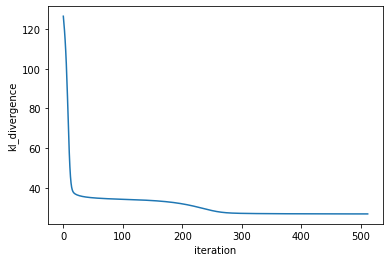

In [12]:
plt.plot([i for i in range(len(divergence_plot[15:]))], divergence_plot[15:])
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


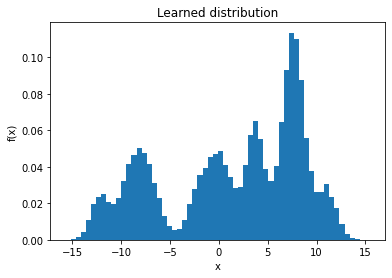

In [21]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights_traditional)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean_traditional[index], scale = np.sqrt([predicted_variance_traditional[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Learned distribution")
plt.show()

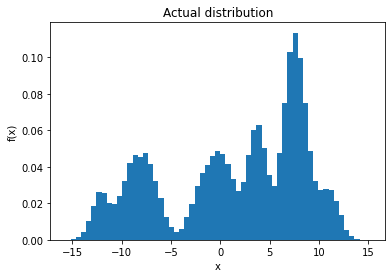

In [22]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Actual distribution")
plt.show()

# Dynamic-update EM

The traditional EM algorithm needs all the datapoint before making any changes to the weights, means and variances. From the idea of reinforcement learning, what if we update every time we see a datapoint (or a batch of datapoints)? In RL, dynamic programming value update will speed up the covergence rate significantly, and is proven to be an unbiased estimator of the actual value function. 

# 2a. Moving average method


In [28]:
predicted_mean_dynamic = np.random.uniform(low=-5, high=5, size=(k, ))
predicted_variance_dynamic = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_dynamic = np.random.random(size=(k, ))
predicted_weights_dynamic = predicted_weights_dynamic / np.sum(predicted_weights_dynamic) 
def dynamicEM():
    global predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    
    while counter < 1000:#prev_divergence - KL_divergence > 0.0001 and KL_divergence > 0:
        
        # This is the old implementation using python loops. I need to redo this part in numpy to optimise bc it takes too much time.
        """for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
            
            denominator_sum = np.sum(probability_matrix[i, :])
            
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum"""
        if counter < 10:
            batch_data = data
        else:
            batch_data = np.random.choice(data, size = (10000, ), replace = False)
        
        probability_matrix = calculate_p_matrix(batch_data, predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
        # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
        
        """for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
            scaling_factor_plot[j].append(np.sum(probability_matrix[:, j]))"""
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
        
        
        if counter < 10 or counter % 10 == 0:

            # Maximisation step
            predicted_weights_dynamic = (1/len(batch_data)) * np.sum(probability_matrix, axis = 0)
            
            mean_matrix = (batch_data * normalised_p_matrix.T).T
            predicted_mean_dynamic = np.sum(mean_matrix, axis = 0)

            predicted_variance_dynamic = np.sum(np.multiply(np.power(np.tile(batch_data, (k, 1)).T - predicted_mean_dynamic, 2), normalised_p_matrix), axis = 0)
        else:
            predicted_weights_dynamic += ((1/len(batch_data)) * np.sum(probability_matrix, axis = 0) - predicted_weights_dynamic) / ((counter % 10) + 1)
            
            mean_matrix = (batch_data * normalised_p_matrix.T).T
            
            predicted_mean_dynamic += (np.sum(mean_matrix, axis = 0) - predicted_mean_dynamic) / ((counter % 10) + 1)
            #0.01 * 2 *(predicted_mean_dynamic - np.sum(mean_matrix, axis = 0))
            predicted_variance_dynamic += (np.sum(np.multiply(np.power(np.tile(batch_data, (k, 1)).T - predicted_mean_dynamic, 2), normalised_p_matrix), axis = 0) - predicted_variance_dynamic) / ((counter % 10) + 1)
            #0.01 * 2 * (predicted_variance_dynamic - np.sum(np.multiply(np.power(np.tile(batch_data, (k, 1)).T - predicted_mean_dynamic, 2), normalised_p_matrix), axis = 0))
            #0.00001 * (np.sum(probability_matrix, axis = 0) / predicted_variance_dynamic + 3* np.sum(np.multiply(np.power(np.tile(batch_data, (k, 1)).T - predicted_mean_dynamic, 2), probability_matrix), axis = 0)/np.power(predicted_variance_dynamic, 2))
    
        #print("mean:", predicted_mean_dynamic, " |  variance:", predicted_variance_dynamic, " |  weights:", predicted_weights_dynamic)
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
        
        if counter % 15 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
    return divergence_plot

divergence_plot = dynamicEM()

kl div: 9610.633458742042
kl div: 239.25685119685684  |  iter: 0  |  difference vs the prev iter: inf
kl div: 171.09587478690457  |  iter: 15  |  difference vs the prev iter: 0.6843891756686844
kl div: 166.88232202702278  |  iter: 30  |  difference vs the prev iter: 0.16003051082188335
kl div: 147.855598717992  |  iter: 45  |  difference vs the prev iter: 0.7993028575611731
kl div: 131.1777876783021  |  iter: 60  |  difference vs the prev iter: -0.1186726024861855
kl div: 126.75987745668967  |  iter: 75  |  difference vs the prev iter: -0.38797691605780926
kl div: 126.23741945765946  |  iter: 90  |  difference vs the prev iter: 0.12061098395122372
kl div: 119.24878097327701  |  iter: 105  |  difference vs the prev iter: -1.6938664390414715
kl div: 120.39361576863655  |  iter: 120  |  difference vs the prev iter: -0.6600615984554992
kl div: 120.96957474174378  |  iter: 135  |  difference vs the prev iter: -0.08547281504588966
kl div: 116.80499461374153  |  iter: 150  |  difference vs th

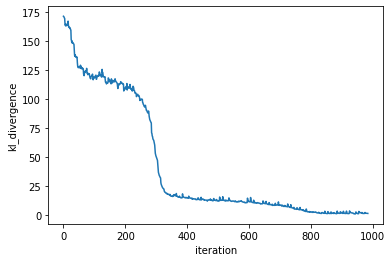

In [29]:
plt.plot([i for i in range(len(divergence_plot[15:]))], divergence_plot[15:])
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


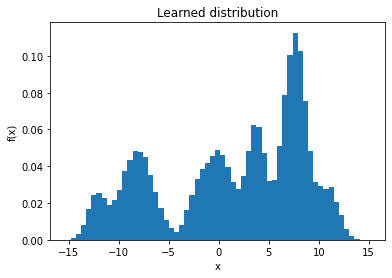

In [30]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights_dynamic)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean_dynamic[index], scale = np.sqrt([predicted_variance_dynamic[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Learned distribution")
plt.show()

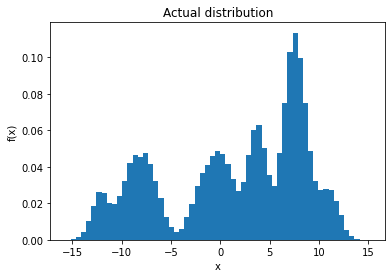

In [31]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Actual distribution")
plt.show()